In [82]:
import pickle
import time
from pathlib import Path

import pandas as pd
import optuna
import lightgbm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

from sklearn.dummy import DummyClassifier

SEED = 123

# Let's get the dataset

We are retrieving the dataset from the file created by the `Data Processing.ipynb` notebook.

In [83]:
df = pd.read_csv('dataset_rw.csv')
for dt_col in ['opp_estimated_close_date', 'CreatedDate', 'first_created_date']:
    df[dt_col] = pd.to_datetime(df[dt_col])
df.head()

,Unnamed: 0,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,...,n_recipients__tc__x,mean_n_recipients__tc__x,n_recipients__fo__x,mean_n_recipients__fo__x,n_recipients__me__x,mean_n_recipients__me__x,first_created_date,CreatedDate__fq,opp_estimated_close_date__fq,target
0,0,0063000000YvrLnAAJ,2022-11-30,False,2021-10-12,0.0,0.0,0.0,0.0,3.0,...,3.0,1.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q2,0
1,1,0061300001ADuHtAAL,2022-08-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q1,0
2,2,0061300001B0qRQAAZ,2022-07-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q1,0
3,3,0061300001IbZXCAA3,2023-02-28,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q3,0
4,4,0061300001KvHGxAAN,2022-11-08,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q2,0


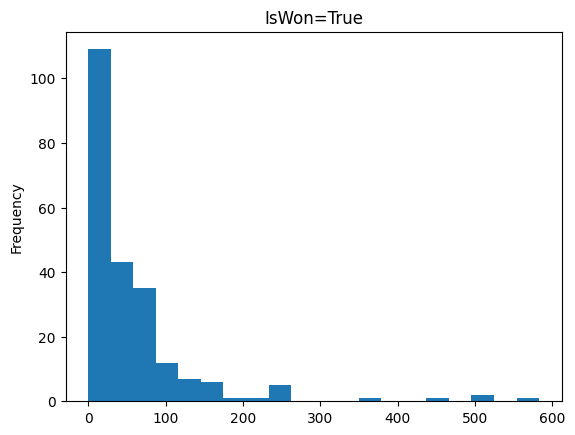

count    224.000000
mean      57.486607
std       82.930085
min        0.000000
25%       10.000000
50%       32.500000
75%       70.000000
max      583.000000
Name: duration, dtype: float64


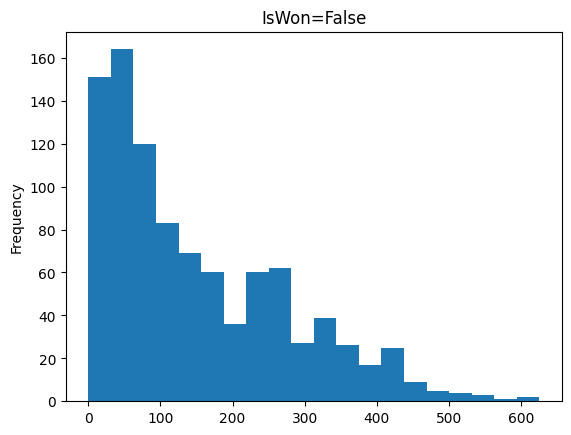

count    963.000000
mean     151.866044
std      126.742949
min        0.000000
25%       48.000000
50%      109.000000
75%      240.000000
max      625.000000
Name: duration, dtype: float64


In [84]:
df = df.sort_values('CreatedDate', ascending=True)

for won in [True, False]:
    df_won = df[df.IsWon == won].copy()
    df_won_unique = df_won.drop_duplicates('OpportunityId').copy() # keep first mention of the opportunity in the dataset
    df_won_unique.loc[:, 'duration'] = (df_won_unique['opp_estimated_close_date'] - df_won_unique['first_created_date']).dt.days
    df_won_unique['duration'].plot.hist(bins=20, title=f'IsWon={won}')
    plt.show()
    print(df_won_unique['duration'].describe())

Based on the above, lost opportunities tend to last much longer (mean=151 days vs 57 days for won opportunities). Thus, the current duration of the opportunity might also be a strong predictor of whether it will close successfully or not.


<Axes: ylabel='Frequency'>

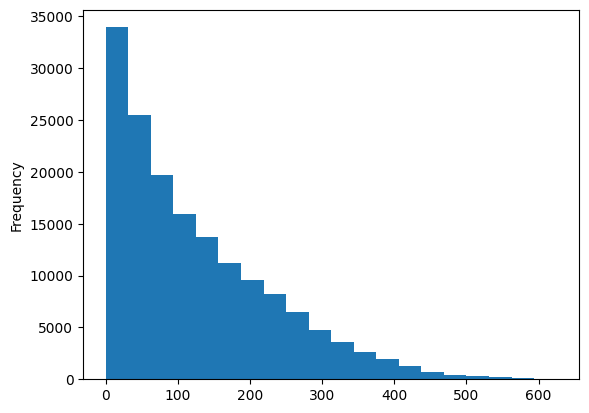

In [85]:
df['current_duration'] = (df['CreatedDate'] - df['first_created_date']).dt.days
df['current_duration'].plot.hist(bins=20)

Let's define some training columns for the baseline model. We will start with the expanding window features representing the number of communications for inbound, outbound, indirect emails as well as meetings.

In [86]:
train_columns = ['current_duration', 'n__fc__rw7', 'n__tc__rw7', 'n__fc__rw30', 'n__me__rw30', 'n__tc__x']
train_columns

['current_duration',
 'n__fc__rw7',
 'n__tc__rw7',
 'n__fc__rw30',
 'n__me__rw30',
 'n__tc__x']

The code below shows the distribution of the positive classes across different levels of data aggregation. 18.9% of opportuntiies are won at some point. Less so, only 8% of opportunity-quarters are positive. This means that opportunities, on average, even if won eventually, are won after several quarters of being open (being a negative class). 

Finally, only 5% of the opportunity-days represent positive classes. This means that there will be a high class imbalance that we will need to account for.

In [87]:
# this column shows the % of the opportunities closed successfully
p_opp_won = df.groupby(['OpportunityId'], as_index=False).agg({'target': 'max'}).target.astype(int).mean()
p_opp_fq_won = df.groupby(['OpportunityId', 'CreatedDate__fq'], as_index=False).agg({'target': 'first'}).target.astype(int).mean()
# and the number of rows that have target == 1
p_samples_won = df.target.mean()

print(f"% of Opportunities Won: {p_opp_won*100:.2f}%")
print(f"% of Opportunity-FQs Won: {p_opp_fq_won*100:.2f}%")
print(f"% of Opportunity-Days Won: {p_samples_won*100:.2f}%")

% of Opportunities Won: 18.87%
% of Opportunity-FQs Won: 8.08%
% of Opportunity-Days Won: 5.01%


The below cell groups all opportunity-days by fiscal quarter and opportunity identifier (target for each group is the same). This is used to split the data into training and test sets - we should avoid putting data points from the same opportunity-quarter into two datasets as it might trick the model.

Additionally, after obtaining training the test sets, we further cut the training set to speed up the baseline model training process. The test set is further split into test and validation sets.

The final distribution of data is as follows:
- training set: 30% of all opportunity-quarters
- test set: 20% of all opportunity-quarters
- validation set: 20% of all opportunity-quarters

The rest 30% is temporarily discarded but will be used in the training set in the future. All opportunity-quarters are split in a stratified way with the outcome variable in mind to ensure that the class imbalance problem doesn't propagate further.

In [88]:
# this identifies unique sets of Opportunities and FQs, because the target is the same for each pair (Opp, FQ)
unique_params = df[['CreatedDate__fq', 'OpportunityId', 'target']].drop_duplicates()

# first we split the whole dataset into what will be test and train, equally, with regards to target
train_params, test_params = train_test_split(unique_params, test_size=0.4, stratify=unique_params['target'], random_state=SEED)

# next, we take only samples of this whole dataset to speed up model training/testing
# taking 0.6 * 0.5 = 0.3 for train 
train_params, _ = train_test_split(train_params, test_size=0.8, stratify=train_params['target'], random_state=SEED)
# taking 0.4*0.5 = 0.2 for test and 0.540.5=0.2 for validation for lgbm
test_params, val_params = train_test_split(test_params, test_size=0.5, stratify=test_params['target'], random_state=SEED)

The following cell assigns opportunity-days to train, test, or validation sets based on their identifiers and quarters.

In [89]:
train = []
test = []
val = []

df_shuffled = df.sample(frac=1, random_state=SEED)
grouped = df_shuffled.groupby(['OpportunityId', 'CreatedDate__fq'])

train_params = set(list(train_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))
test_params = set(list(test_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))
val_params = set(list(val_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))


for name, group in grouped:
    if name in train_params:
        train.append(group)
    elif name in test_params:
        test.append(group)
    elif name in val_params:
        val.append(group)

train = pd.concat(train)
test = pd.concat(test)
val = pd.concat(val)


In [90]:
#print(train[train_columns].shape, test[train_columns].shape, val[train_columns].shape)
print(f"Opportunity-days won in df: {df.target.mean():.4f}")
print(f"Opportunity-days won in train: {train.target.mean():.4f}")
print(f"Opportunity-days won in test: {test.target.mean():.4f}")
print(f"Opportunity-days won in test: {val.target.mean():.4f}")

Opportunity-days won in df: 0.0501
Opportunity-days won in train: 0.0480
Opportunity-days won in test: 0.0517
Opportunity-days won in test: 0.0528


From the output above, we can see that the number ratio of "won" rows is the relatively similar between train, test, and the whole dataset. Before using stratified sampling, it used to be 0.038 for train (10 times smaller than the "true" value!)

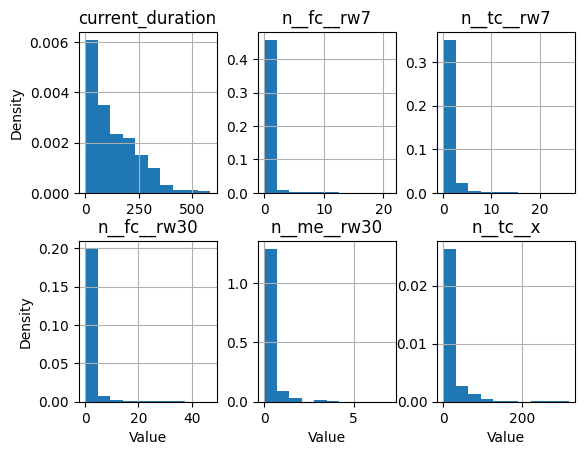

In [91]:
fig, ax = plt.subplots(2, 3)
train[train_columns].hist(density=True, ax=ax.flatten())
ax[1][0].set_xlabel('Value')
ax[1][1].set_xlabel('Value')
ax[1][2].set_xlabel('Value')
ax[0][0].set_ylabel('Density')
ax[1][0].set_ylabel('Density')
plt.show()

Since we are using SVCs, it's a good practice to normalize the data. For that, we will take the log of data to reduce its skewness attributable to the high sparsity. Then, we rescale the data to a smaller range of values to optimize for the SVC's speed. We train the scaler on train data but then apply it to the testing and validation sets as well. Final data distributions for train set are provided below

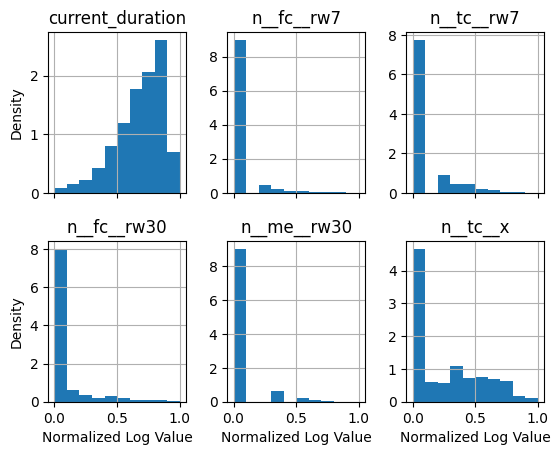

In [92]:
scaler = None
for dataset in [train, test, val]:
    for feature in train_columns:
        dataset[feature] = np.log1p(dataset[feature])

    # this condition will be entered only for the train set
    if not scaler:
        scaler = MinMaxScaler(feature_range=(0,1)) 
        scaler.fit(dataset[train_columns])
        dataset[train_columns] = scaler.transform(dataset[train_columns])
        
        fig, ax = plt.subplots(2, 3, sharex=True)
        train[train_columns].hist(density=True, ax=ax.flatten()[:len(train_columns)])
        ax[1][0].set_xlabel('Normalized Log Value')
        ax[1][1].set_xlabel('Normalized Log Value')
        ax[1][2].set_xlabel('Normalized Log Value')
        ax[0][0].set_ylabel('Density')
        ax[1][0].set_ylabel('Density')
        plt.show()
    else:
        dataset[train_columns] = scaler.transform(dataset[train_columns])
    



Now, let's add some synthetical samples to the train data to decrease the imbalance. We use SMOTE for this.

In [11]:
# let's augment the train dataset a bit and generate more positive samples :)
smote = SMOTE(sampling_strategy=1/9, random_state=SEED)
train, target = smote.fit_resample(train[train_columns], train.target)

train['target'] = target


In [12]:
print(train[train_columns].shape, test[train_columns].shape)
print(f"Opportunity-days won in train: {train.target.mean():.3f}")
print(f"Opportunity-days won in test: {test.target.mean():.3f}")

(19928, 5) (32508, 5)
Opportunity-days won in train: 0.100
Opportunity-days won in test: 0.052


In [51]:
def get_metrics(y_true, y_pred, y_proba, sample_weights=None) -> dict:
    metric = dict()
    metric['f1'] = metrics.f1_score(y_true, y_pred)
    metric['precision'] = metrics.precision_score(y_true, y_pred)
    metric['recall'] = metrics.recall_score(y_true, y_pred)
    metric['matt_score'] = metrics.matthews_corrcoef(y_true, y_pred)
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred)
    metric['pr_auc'] = metrics.auc(recall, precision)
    metric['log_loss'] = metrics.log_loss(y_true, y_proba)
    metric['bas'] = metrics.balanced_accuracy_score(y_true, y_pred)
    return metric

def get_report(metrics_dict, prefix=""):
    for key, value in metrics_dict.items():
        tabs = '\t\t' if len(key) <= 6 else '\t'
        print(f"{prefix}\t{key}:{tabs}{value:.4f}")

In [14]:
LOSS_FUNCTION = 'log_loss'
DIRECTION = 'minimize'

In [15]:
def objective_for_stratified(train_data: pd.DataFrame, val_data, trial: optuna.Trial, get_estimator) -> float:
    """
    This objective splits the data by CreatedDate__fq and builds Train dataset so that
    no data from the future dates is available in the Test dataset
    
    Inputs
    ------------
    train_data: pd.DataFrame - the train dataset
    val_data: pd.DataFrame - the validation dataset 
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    model = get_estimator(trial)  # find optimal parameters for the model
    avg_metric = []
    splits = 0
    x_train, x_test, y_train, y_test = train_data[train_columns], val_data[train_columns], train_data.target, val_data.target
        
    model.fit(x_train, y_train)
        
    # generate predictions for the unseen quarter and save it
    y_proba = model.predict_proba(x_test)[:, 1]
    y_pred = model.predict(x_test)
    metrics = get_metrics(y_test, y_pred, y_proba)

    return metrics[LOSS_FUNCTION]


def optimize(train_data, val_data, objective, get_estimator, n_trials, n_jobs=1):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    objective: function - the objective to be minimized
    n_trials: int - the number of model iterations 
    
    Returns
    ------------
    Model - the fitted model object
    """

    # optimize the model on `n_trials`
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction=DIRECTION, sampler=sampler)
    study.optimize(lambda trial: objective(train_data, val_data, trial, get_estimator), n_trials=n_trials, n_jobs=n_jobs)

    # retrieve the best model and fit it
    model = get_estimator(trial=None, params=study.best_params)
    model.fit(train_data[train_columns], train_data.target)
    return model

## Candidate 0: Dummy Classifier

In [16]:
timestamp = int(time.time())

In [17]:
dummy = DummyClassifier(strategy='stratified', random_state=SEED)
dummy.fit(train[train_columns], train.target)
# get predictions 
test['dummy_pred'] = dummy.predict(test[train_columns])
test['dummy_proba'] = dummy.predict_proba(test[train_columns])[:, 1]
train['dummy_pred'] = dummy.predict(train[train_columns])
train['dummy_proba'] = dummy.predict_proba(train[train_columns])[:, 1]
val['dummy_pred'] = dummy.predict(val[train_columns])
val['dummy_proba'] = dummy.predict_proba(val[train_columns])[:, 1]

get_report(get_metrics(train.target, train.dummy_pred, train.dummy_proba), prefix="Dummy Train")
print()
get_report(get_metrics(test.target, test.dummy_pred, test.dummy_proba), prefix="Dummy Test ")
print()
get_report(get_metrics(val.target, val.dummy_pred, val.dummy_proba), prefix="Dummy Val ")

Dummy Train	f1:		0.1029
Dummy Train	precision:	0.1033
Dummy Train	recall:		0.1024
Dummy Train	matt_score:	0.0037
Dummy Train	pr_auc:		0.1477
Dummy Train	log_loss:	6.4353

Dummy Test 	f1:		0.0680
Dummy Test 	precision:	0.0520
Dummy Test 	recall:		0.0982
Dummy Test 	matt_score:	0.0005
Dummy Test 	pr_auc:		0.0984
Dummy Test 	log_loss:	5.0138

Dummy Val 	f1:		0.0615
Dummy Val 	precision:	0.0474
Dummy Val 	recall:		0.0874
Dummy Val 	matt_score:	-0.0079
Dummy Val 	pr_auc:		0.0915
Dummy Val 	log_loss:	5.0776


## Candidate 1: SVC - Support Vector Classifier

In [55]:
svc_trial_config = {
  'suggest_float':
    {
        'C': {'name': 'C', 'low': 1e-3, 'high': 10.0, 'log': True},
        'gamma': {'name': 'gamma', 'low': 0.0001, 'high': 1, 'log': True},
        'coef0': {'name': 'coef0', 'low': -3, 'high': 3}
    },
    'suggest_int':
    {
        'degree': {'name': 'degree', 'low': 1, 'high': 7}
    }
}

def get_svc_estimator(trial: optuna.Trial, params: dict = None):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    if params is None:
        params = {}
        trial_node = svc_trial_config
        for method_name, method_params in trial_node.items():
            method = getattr(trial, method_name)
            for name, kwargs in method_params.items():
                params[name] = method(**kwargs)
    print(params)
                
    model = SVC(
        kernel='poly',
        tol=2,
        verbose=0,
        random_state=SEED, 
        probability=True,
        class_weight='balanced',  # because of class imbalance
        **params)
    return model

svc = optimize(train, val, objective_for_stratified, get_svc_estimator, 20, n_jobs=6)

[I 2023-11-24 13:29:18,437] A new study created in memory with name: no-name-912de1d2-8df8-48e7-9e5b-1f2133452331


{'C': 0.08402891145326068, 'gamma': 0.008723958625462528, 'coef0': -0.08815341446477953, 'degree': 7}
{'C': 5.204175190889647, 'gamma': 0.0021616050284476575, 'coef0': -0.1727435918927145, 'degree': 1}
{'C': 0.6491522239793472, 'gamma': 0.4111928783784729, 'coef0': 2.9285774687117447, 'degree': 2}
{'C': 1.2288079243940842, 'gamma': 0.016978616337873117, 'coef0': 0.41616493548848066, 'degree': 4}
{'C': 0.016380418190368687, 'gamma': 0.7601350032879629, 'coef0': 2.0002556791496104, 'degree': 3}
{'C': 0.1337033668317432, 'gamma': 0.00024253680388514303, 'coef0': -0.144338262671047, 'degree': 1}


[I 2023-11-24 13:30:46,774] Trial 4 finished with value: 0.2681176148540953 and parameters: {'C': 0.016380418190368687, 'gamma': 0.7601350032879629, 'coef0': 2.0002556791496104, 'degree': 3}. Best is trial 4 with value: 0.2681176148540953.


{'C': 0.002020486763500432, 'gamma': 0.00011660444714143184, 'coef0': 2.7567883080828004, 'degree': 7}


[I 2023-11-24 13:31:02,541] Trial 1 finished with value: 0.560661675129414 and parameters: {'C': 5.204175190889647, 'gamma': 0.0021616050284476575, 'coef0': -0.1727435918927145, 'degree': 1}. Best is trial 4 with value: 0.2681176148540953.


{'C': 0.006677004986051821, 'gamma': 0.0008165114444851518, 'coef0': 0.97708769205973, 'degree': 1}


[I 2023-11-24 13:31:03,151] Trial 2 finished with value: 0.2065594209060681 and parameters: {'C': 0.6491522239793472, 'gamma': 0.4111928783784729, 'coef0': 2.9285774687117447, 'degree': 2}. Best is trial 2 with value: 0.2065594209060681.


{'C': 0.23944272324479546, 'gamma': 0.006778127581734258, 'coef0': -2.945830012619056, 'degree': 3}


[I 2023-11-24 13:31:16,768] Trial 3 finished with value: 0.4648779600373958 and parameters: {'C': 1.2288079243940842, 'gamma': 0.016978616337873117, 'coef0': 0.41616493548848066, 'degree': 4}. Best is trial 2 with value: 0.2065594209060681.


{'C': 0.053229016766601196, 'gamma': 0.006205432418940564, 'coef0': -2.1674584684555382, 'degree': 4}


[I 2023-11-24 13:31:36,173] Trial 5 finished with value: 0.21464664536747102 and parameters: {'C': 0.1337033668317432, 'gamma': 0.00024253680388514303, 'coef0': -0.144338262671047, 'degree': 1}. Best is trial 2 with value: 0.2065594209060681.


{'C': 1.9072965231577952, 'gamma': 0.06285217092595427, 'coef0': -1.7705510001920737, 'degree': 7}


[I 2023-11-24 13:31:41,343] Trial 0 finished with value: 0.20675079904702234 and parameters: {'C': 0.08402891145326068, 'gamma': 0.008723958625462528, 'coef0': -0.08815341446477953, 'degree': 7}. Best is trial 2 with value: 0.2065594209060681.


{'C': 0.08763752506125322, 'gamma': 0.05205551889637609, 'coef0': -2.9153574022632185, 'degree': 2}


[I 2023-11-24 13:32:54,351] Trial 8 finished with value: 0.29595646474026677 and parameters: {'C': 0.23944272324479546, 'gamma': 0.006778127581734258, 'coef0': -2.945830012619056, 'degree': 3}. Best is trial 2 with value: 0.2065594209060681.


{'C': 0.1264246430704346, 'gamma': 0.0007676073341270145, 'coef0': -2.525209167616514, 'degree': 3}


[I 2023-11-24 13:33:04,711] Trial 6 finished with value: 2.104878603417209 and parameters: {'C': 0.002020486763500432, 'gamma': 0.00011660444714143184, 'coef0': 2.7567883080828004, 'degree': 7}. Best is trial 2 with value: 0.2065594209060681.


{'C': 0.1463161543351399, 'gamma': 0.012759758619363135, 'coef0': 1.7636826693459646, 'degree': 2}


[I 2023-11-24 13:33:17,553] Trial 10 finished with value: 0.2306362954342733 and parameters: {'C': 1.9072965231577952, 'gamma': 0.06285217092595427, 'coef0': -1.7705510001920737, 'degree': 7}. Best is trial 2 with value: 0.2065594209060681.


{'C': 0.001237212450651191, 'gamma': 0.0003741660665766633, 'coef0': 2.1507990858209656, 'degree': 1}


[I 2023-11-24 13:33:24,918] Trial 7 finished with value: 0.21604875266058832 and parameters: {'C': 0.006677004986051821, 'gamma': 0.0008165114444851518, 'coef0': 0.97708769205973, 'degree': 1}. Best is trial 2 with value: 0.2065594209060681.


{'C': 8.942043398665433, 'gamma': 0.5762774219836747, 'coef0': 2.662236430122676, 'degree': 5}


/home/viktor/Minerva/Senior Year/CP/capstone-rg/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-24 13:34:19,517] Trial 9 finished with value: 0.26183847627344126 and parameters: {'C': 0.053229016766601196, 'gamma': 0.006205432418940564, 'coef0': -2.1674584684555382, 'degree': 4}. Best is trial 2 with value: 0.2065594209060681.


{'C': 0.5204462597641594, 'gamma': 0.08631519198956282, 'coef0': 2.982839506801624, 'degree': 6}


/home/viktor/Minerva/Senior Year/CP/capstone-rg/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-24 13:34:38,307] Trial 11 finished with value: 0.2610793094233387 and parameters: {'C': 0.08763752506125322, 'gamma': 0.05205551889637609, 'coef0': -2.9153574022632185, 'degree': 2}. Best is trial 2 with value: 0.2065594209060681.


{'C': 0.37576507738393067, 'gamma': 0.8095551077645928, 'coef0': 2.956797404711831, 'degree': 6}


[I 2023-11-24 13:35:22,933] Trial 12 finished with value: 0.6980851717145745 and parameters: {'C': 0.1264246430704346, 'gamma': 0.0007676073341270145, 'coef0': -2.525209167616514, 'degree': 3}. Best is trial 2 with value: 0.2065594209060681.


{'C': 0.41867877369359274, 'gamma': 0.6607462360880457, 'coef0': 2.989113862535838, 'degree': 6}


[I 2023-11-24 13:35:23,394] Trial 13 finished with value: 0.49275079575930386 and parameters: {'C': 0.1463161543351399, 'gamma': 0.012759758619363135, 'coef0': 1.7636826693459646, 'degree': 2}. Best is trial 2 with value: 0.2065594209060681.


{'C': 0.529934263812732, 'gamma': 0.858718877036194, 'coef0': -0.9354051073451933, 'degree': 6}


[I 2023-11-24 13:35:32,236] Trial 14 finished with value: 0.2190890167153626 and parameters: {'C': 0.001237212450651191, 'gamma': 0.0003741660665766633, 'coef0': 2.1507990858209656, 'degree': 1}. Best is trial 2 with value: 0.2065594209060681.
[I 2023-11-24 13:36:12,240] Trial 16 finished with value: 0.22622742477431879 and parameters: {'C': 0.5204462597641594, 'gamma': 0.08631519198956282, 'coef0': 2.982839506801624, 'degree': 6}. Best is trial 2 with value: 0.2065594209060681.
[I 2023-11-24 13:36:53,167] Trial 15 finished with value: 0.3553131971888246 and parameters: {'C': 8.942043398665433, 'gamma': 0.5762774219836747, 'coef0': 2.662236430122676, 'degree': 5}. Best is trial 2 with value: 0.2065594209060681.
[I 2023-11-24 13:37:06,330] Trial 19 finished with value: 0.22114540635136576 and parameters: {'C': 0.529934263812732, 'gamma': 0.858718877036194, 'coef0': -0.9354051073451933, 'degree': 6}. Best is trial 2 with value: 0.2065594209060681.
[I 2023-11-24 13:37:12,533] Trial 17 fin

{'C': 0.6491522239793472, 'gamma': 0.4111928783784729, 'coef0': 2.9285774687117447, 'degree': 2}


In [56]:
# get predictions 
test['svc_proba'] = svc.predict_proba(test[train_columns])[:, 1]
test['svc_pred'] = svc.predict(test[train_columns])
train['svc_proba'] = svc.predict_proba(train[train_columns])[:, 1]
train['svc_pred'] = svc.predict(train[train_columns])
val['svc_proba'] = svc.predict_proba(val[train_columns])[:, 1]
val['svc_pred'] = svc.predict(val[train_columns])

get_report(get_metrics(train.target, train.svc_pred, train.svc_proba), prefix="SVC Train")
print()
get_report(get_metrics(test.target, test.svc_pred, test.svc_proba), prefix="SVC Test ")
print()
get_report(get_metrics(val.target, val.svc_pred, val.svc_proba), prefix="SVC Val ")

SVC Train	f1:		0.4069
SVC Train	precision:	0.2659
SVC Train	recall:		0.8665
SVC Train	matt_score:	0.3845
SVC Train	pr_auc:		0.5728
SVC Train	log_loss:	0.2278
SVC Train	bas:		0.8004

SVC Test 	f1:		0.1794
SVC Test 	precision:	0.1062
SVC Test 	recall:		0.5782
SVC Test 	matt_score:	0.1540
SVC Test 	pr_auc:		0.3531
SVC Test 	log_loss:	0.1988
SVC Test 	bas:		0.6564

SVC Val 	f1:		0.1832
SVC Val 	precision:	0.1072
SVC Val 	recall:		0.6287
SVC Val 	matt_score:	0.1630
SVC Val 	pr_auc:		0.3778
SVC Val 	log_loss:	0.2125
SVC Val 	bas:		0.6685


## Candidate 2: LightGBM - Random Forest

For the LightGBM, there is a small template that uses optuna to optimize some hyperparameters. Let's train it in 40 iterations, optimizing over a subset of hyperparameters. A more thorough analysis is yet to come.

Here, we will use the validation set to guide the training process and reduce overfit. The training metric will be log-loss to account for the probabilities and not discrete values

In [20]:
trial_config = {
  'suggest_float':
    {
        'reg_alpha': {'name': 'reg_alpha', 'low': 1e-2, 'high': 10.0, 'log': True},
        'reg_lambda': {'name': 'reg_lambda', 'low': 1e-2, 'high': 10.0, 'log': True},
        'learning_rate': {'name': 'learning_rate', 'low': 0.0001, 'high': 0.1, 'log': True},
        'subsample': {'name': 'subsample', 'low': 0.2, 'high': 1},
        'colsample_bytree': {'name': 'colsample_bytree', 'low': 0.2, 'high': 1},
        'min_split_gain': {'name': 'min_split_gain', 'low': 0.01, 'high': 0.7},
        'min_child_weight': {'name': 'min_child_weight', 'low': 0.0001, 'high': 0.4, 'log': True},
    },
  'suggest_int':
    {
        'n_estimators': {'name': 'n_estimators', 'low': 10, 'high': 1000},
        'num_leaves': {'name': 'num_leaves', 'low': 7, 'high': 2047},
        'subsample_freq': {'name': 'subsample_freq', 'low': 1, 'high': 100},
        'min_child_samples': {'name': 'min_child_samples', 'low': 10, 'high': 3000},
    }
    
}

In [21]:
# def objective_timecv_everyday(data: pd.DataFrame, trial: optuna.Trial) -> float:
#     """
#     DEPRECATED
    
#     This objective splits the data by CreatedDate__fq and builds Train dataset so that
#     no data from the future dates is available in the Test dataset
    
#     Inputs
#     ------------
#     data: pd.DataFrame - the dataset
#     trial: optuna.Trial - current trial information
    
#     Returns
#     ------------
#     np.float64 - average cvtime log_loss after training the model
#     """
#     def custom_time_split(x, y):
#         groups = x.groupby('CreatedDate__fq')
#         train_idx, test_idx = [], []
#         for _, group in groups:
#             test_idx = group.index
#             if train_idx:
#                 yield train_idx, test_idx
#             train_idx.extend(group.index)

#     data = data.sort_values(by=['CreatedDate'], ascending=True)
#     X, y = data, data.target  # get predictors and outputs 
#     model = get_estimator(trial)  # find optimal parameters for the model
#     avg_metric = []
#     splits = 0
#     for train_idx, test_idx in tqdm(custom_time_split(X, y)):
#         splits += 1
#         # split the dataset into test and train using the custom function above
#         x_train, y_train = X.loc[train_idx], y.loc[train_idx]
#         x_test, y_test = X.loc[test_idx], y.loc[test_idx]
        
#         # use the previously fitted model if possible
#         boost = model if model.__sklearn_is_fitted__() else None
        
#         model.fit(x_train[train_columns], y_train, init_model=boost)
        
#         # generate predictions for the unseen quarter and save it
#         y_pred = model.predict_proba(x_test[train_columns])[:, 1]
#         metric = log_loss(y_test, y_pred, labels=[0, 1])
#         avg_metric.append(metric)

#     weights = (np.arange(splits) + 1) / np.sum(np.arange(splits))
    
#     return np.dot(avg_metric, weights)





def get_lgbm_estimator(trial: optuna.Trial, params: dict = None):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    if params is None:
        params = {}
        trial_node = trial_config
        for method_name, method_params in trial_node.items():
            method = getattr(trial, method_name)
            for name, kwargs in method_params.items():
                params[name] = method(**kwargs)
                
    model = lightgbm.LGBMClassifier(
        random_state=SEED, 
        objective='binary',  # classification
        importance_type='gain', 
        class_weight='balanced',  # because of class imbalance
        **params)
    return model




In [22]:
lgbm = optimize(train, val, objective_for_stratified, get_lgbm_estimator, 40)

[I 2023-11-23 14:02:53,966] A new study created in memory with name: no-name-a0de0ac1-3c0f-45d7-863c-0efee74aa8b8
[I 2023-11-23 14:02:54,847] Trial 0 finished with value: 0.6087877432703336 and parameters: {'reg_alpha': 1.2285916427548795, 'reg_lambda': 0.07218018732952583, 'learning_rate': 0.0004792414358623592, 'subsample': 0.6410518152663129, 'colsample_bytree': 0.7755751758284506, 'min_split_gain': 0.30194345748587803, 'min_child_weight': 0.3410134276028888, 'n_estimators': 688, 'num_leaves': 988, 'subsample_freq': 40, 'min_child_samples': 1036}. Best is trial 0 with value: 0.6087877432703336.
[I 2023-11-23 14:02:55,275] Trial 1 finished with value: 0.674672548280127 and parameters: {'reg_alpha': 1.5386828816779856, 'reg_lambda': 0.20687915518060288, 'learning_rate': 0.0001510197301208727, 'subsample': 0.5184354042643451, 'colsample_bytree': 0.7903963245856287, 'min_split_gain': 0.13591929401291497, 'min_child_weight': 0.0004285364338531866, 'n_estimators': 536, 'num_leaves': 1092,

In [30]:
test['lgbm_proba'] = lgbm.predict_proba(test[train_columns])[:, 1]
test['lgbm_pred'] = (test['lgbm_proba'] > 0.5).astype(int)
train['lgbm_proba'] = lgbm.predict_proba(train[train_columns])[:, 1]
train['lgbm_pred'] = (train['lgbm_proba'] > 0.5).astype(int)
val['lgbm_proba'] = lgbm.predict_proba(val[train_columns])[:, 1]
val['lgbm_pred'] = (val['lgbm_proba'] > 0.5).astype(int)

## Let's compare 'em

The code cell below outputs metrics on the predictions for test and train classes as well as produces confusion matrices and precision-recall AUC curves.

Train	dummy:	f1:		0.1029
Train	dummy:	precision:	0.1033
Train	dummy:	recall:		0.1024
Train	dummy:	matt_score:	0.0037
Train	dummy:	pr_auc:		0.1477
Train	dummy:	log_loss:	6.4353
Train	dummy:	bas:		0.5019

Train	svc:	f1:		0.4069
Train	svc:	precision:	0.2659
Train	svc:	recall:		0.8665
Train	svc:	matt_score:	0.3845
Train	svc:	pr_auc:		0.5728
Train	svc:	log_loss:	0.2278
Train	svc:	bas:		0.8004

Train	lgbm:	f1:		0.5099
Train	lgbm:	precision:	0.3564
Train	lgbm:	recall:		0.8956
Train	lgbm:	matt_score:	0.4952
Train	lgbm:	pr_auc:		0.6312
Train	lgbm:	log_loss:	0.3092
Train	lgbm:	bas:		0.8580

Test	dummy:	f1:		0.0680
Test	dummy:	precision:	0.0520
Test	dummy:	recall:		0.0982
Test	dummy:	matt_score:	0.0005
Test	dummy:	pr_auc:		0.0984
Test	dummy:	log_loss:	5.0138
Test	dummy:	bas:		0.5003

Test	svc:	f1:		0.1794
Test	svc:	precision:	0.1062
Test	svc:	recall:		0.5782
Test	svc:	matt_score:	0.1540
Test	svc:	pr_auc:		0.3531
Test	svc:	log_loss:	0.1988
Test	svc:	bas:		0.6564

Test	lgbm:	f1:		0.2021
Test	lgbm:	

<Figure size 640x480 with 0 Axes>

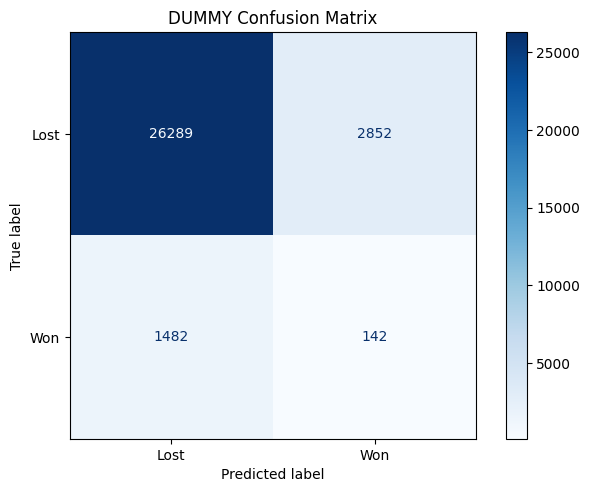

<Figure size 640x480 with 0 Axes>

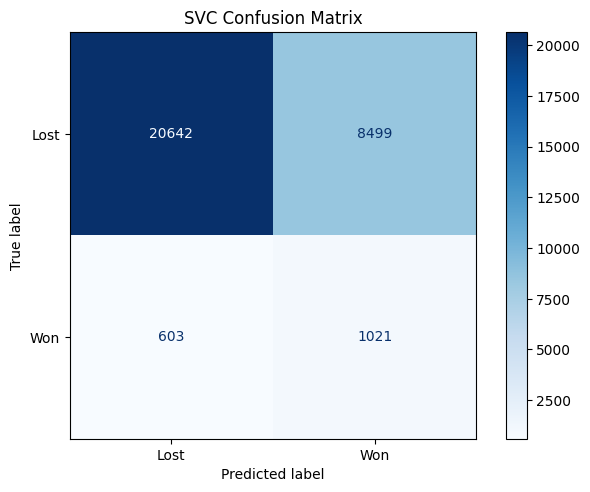

<Figure size 640x480 with 0 Axes>

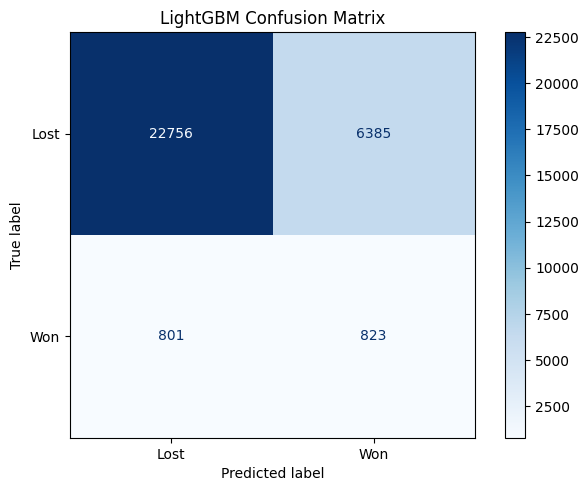

<Figure size 640x480 with 0 Axes>

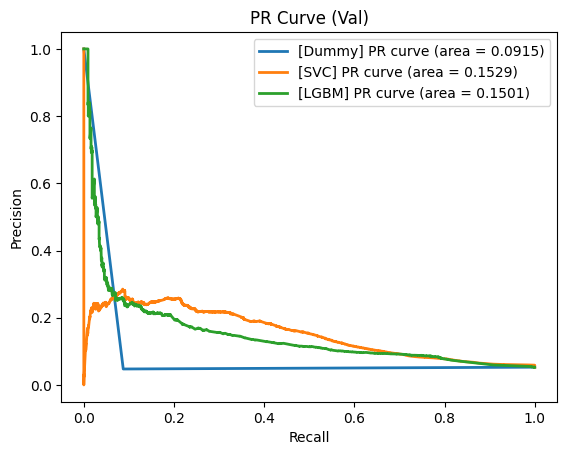

<Figure size 640x480 with 0 Axes>

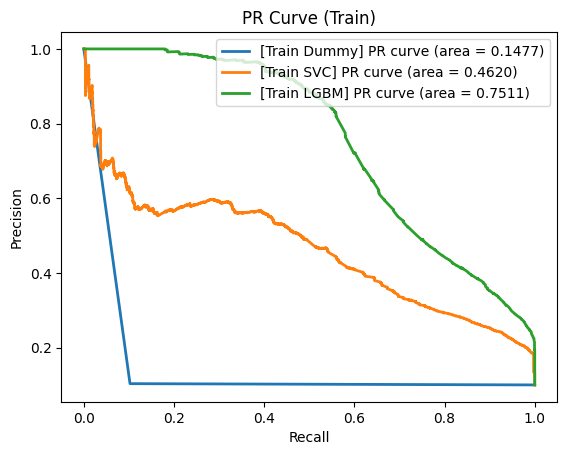

In [57]:
def plot_confusion_matrix(y_true, y_pred, classes, order, title=None, normalize=None):    
    plt.clf()
    if not title:
        title = 'Confusion Matrix, Without Normalization'

    fig, ax = plt.subplots()
    disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, cmap=plt.cm.Blues, labels=order)
    fig.tight_layout()
    ax.set(title=title, xticklabels=classes, yticklabels=classes)
    plt.show()


def plot_pr_auc(y_true, y_pred, labels=None, title="PR Curve"):    
    plt.clf()
    fig, ax = plt.subplots()
    if labels:
        for label, pred in zip(labels, y_pred):
            precision, recall, _ = metrics.precision_recall_curve(y_true, pred)
            pr_auc = metrics.auc(recall, precision)
            ax.plot(recall, precision, lw=2, label=f'[{label}] PR curve (area = {pr_auc:.4f})')
    else:
        ax.plot(recall, precision, lw=2, label=f'[Model] PR curve (area = {pr_auc:.4f})')
        
    ax.set(xlabel='Recall', ylabel='Precision', title=title)
    ax.legend(loc='upper right')
    plt.show()

test.target = test.target.astype(int)

for ds, label in [(train, 'Train'), (test, 'Test'), (val, 'Val')]:
    for model_name in ['dummy', 'svc', 'lgbm']:
        get_report(get_metrics(ds.target, ds[f'{model_name}_pred'], ds[f'{model_name}_proba']), prefix=f"{label}\t{model_name}:")
        print()

plot_confusion_matrix(val.target.astype(int), val.dummy_pred, ['Lost', 'Won'], [0, 1], title="DUMMY Confusion Matrix")
plot_confusion_matrix(val.target.astype(int), val.svc_pred, ['Lost', 'Won'], [0, 1], title="SVC Confusion Matrix")
plot_confusion_matrix(val.target.astype(int), val.lgbm_pred, ['Lost', 'Won'], [0, 1], title="LightGBM Confusion Matrix")
plot_pr_auc(val.target.astype(int), [val.dummy_proba, val.svc_proba, val.lgbm_proba], labels=['Dummy', 'SVC', 'LGBM'], title='PR Curve (Val)')
plot_pr_auc(train.target.astype(int), [train.dummy_proba, train.svc_proba, train.lgbm_proba], labels=['Train Dummy', 'Train SVC', 'Train LGBM'], title='PR Curve (Train)')


Based on the figures above, the following conclusions can be made about the baseline models. First, there is a clear overfit for both models, as they perform relatively well on the train sets but much less so on the test sets. While this is expected for SVCs that weren't tested against validation sets during training, this is unexpected for the LightGBM (with PR AUC being 0.1 for test but 0.71 for train), whose metric evaluation was conducted on the validation set during testing.

Nevertheless, SVC seems to perform marginally better - recall, which is an important metric in this scenario as we want to minimize false negatives, is significantly higher. SVC is generally better at figuring positive cases while not significantly losing in precision to LightGBM. It is likely that over larger sets of hyperparameters, LightGBM will be able to reduce its overfit and perform better on unseen data.

<Figure size 640x480 with 0 Axes>

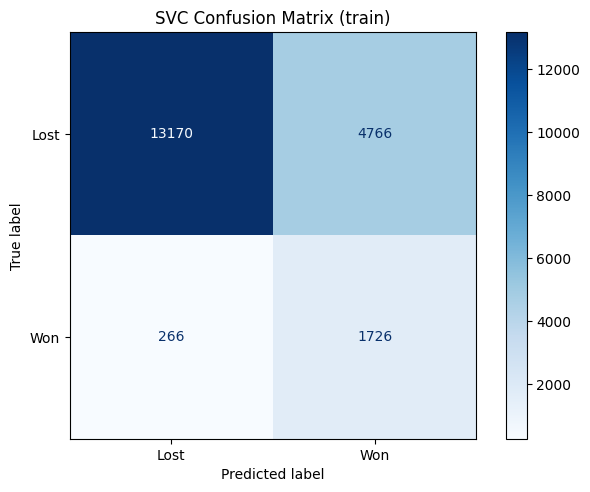

<Figure size 640x480 with 0 Axes>

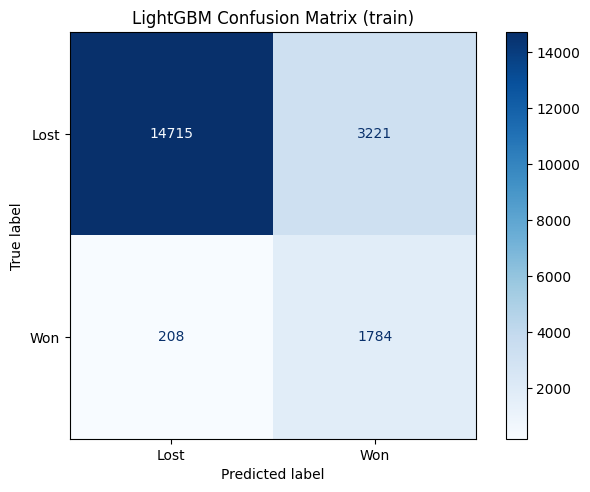

In [59]:
plot_confusion_matrix(train.target.astype(int), train.svc_pred, ['Lost', 'Won'], [0, 1], title="SVC Confusion Matrix (train)")
plot_confusion_matrix(train.target.astype(int), train.lgbm_pred, ['Lost', 'Won'], [0, 1], title="LightGBM Confusion Matrix (train)")

In [58]:
models_dir = 'models'
Path(models_dir).mkdir(parents=True, exist_ok=True)

def save_all_models_and_pred(models, labels, train_df, test_df):
    model_path = f"{models_dir}/{int(time.time())}"
    Path(model_path).mkdir(parents=True)

    for m, l in zip(models, labels):
        with open(f'{model_path}/{l}_model.pkl', 'wb') as f:
            pickle.dump(m, f)
    train_df.to_csv(f'{model_path}/train.csv')
    test_df.to_csv(f'{model_path}/test.csv')


models = [dummy, svc, lgbm, scaler]
labels = ['dummy', 'svc', 'lgbm', 'minmaxscaler']
save_all_models_and_pred(models, labels, train, test)

In [60]:
svc

SVC(C=0.6491522239793472, class_weight='balanced', coef0=2.9285774687117447,
    degree=2, gamma=0.4111928783784729, kernel='poly', probability=True,
    random_state=123, tol=2, verbose=0)

In [53]:
with open('models/1700720248/svc_model.pkl', 'rb') as f:
    svc = pickle.load(f)
svc

SVC(C=0.2787797362942396, class_weight='balanced', coef0=2.984111382611347,
    degree=6, gamma=0.03209436421250294, kernel='poly', probability=True,
    random_state=123, tol=2, verbose=0)

In [39]:
dir(svc_model)
params = svc_model.get_params()
for param in params:
    print(f"{param}={params[param]}")

C	0.2787797362942396
break_ties	False
cache_size	200
class_weight	balanced
coef0	2.984111382611347
decision_function_shape	ovr
degree	6
gamma	0.03209436421250294
kernel	poly
max_iter	-1
probability	True
random_state	123
shrinking	True
tol	2
verbose	0


In [44]:
for name, feature in zip(lgbm.feature_name_, lgbm.feature_importances_):
    print(f"{name}:\t{feature/lgbm.feature_importances_.sum()*100:.3f}%")

current_duration:	47.440%
n__fc__rw7:	1.804%
n__tc__rw7:	8.487%
n__fc__rw30:	31.834%
n__me__rw30:	10.435%


In [48]:
for name, feature in zip(svc.feature_names_in_, svc.feature_importances_):
    print(f"{name}:\t{feature/lgbm.feature_importances_.sum()*100:.3f}%")

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [ ]:
svc._fea